# *Amazon Apparel Recommendation System*

In [1]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')

In [2]:
# loading data using pandas read_json file
# this file contains all the information about the products
data = pd.read_json('C:/Users/DELL/Downloads/ML-NLP/ML-NLP/Recommendation System/tops_fashion.json')

In [3]:
print('Number of data points(number of products) :',data.shape[0],\
      'Number of features/variables:',data.shape[1])

Number of data points(number of products) : 183138 Number of features/variables: 19


# Dataset
- No of Rows and columns

In [4]:
#each product/item has 19 features in raw dataset
data.columns

Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')

### using only 7 features in this workshop
1. asin ( Amazon standard identification number)
2. brand (brand to which the product belongs to)
3. color ( color information of apparel, it can contain many colors as a value ex: red and black stripes)
4. product_type_name (type of the apparel, ex: Shirt/Tshirt)
5. medium_image_url (url of the image)
6. title(title of the product)
7. formatted_price(price of the product)

In [5]:
#taken subset of data
data = data[['asin','brand','color','medium_image_url','product_type_name', 'title','formatted_price']]

In [6]:
print('Number of data points(number of products) :',data.shape[0],\
      'Number of features/variables:',data.shape[1])
data.head() #prints top rows in the table

Number of data points(number of products) : 183138 Number of features/variables: 7


,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,FNC7C,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Izo Tunic,None
2,B01JDPCOHO,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Won Top,None
3,B01N19U5H5,Focal18,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26


## Exploratory Data Analysis
- exploring each and every feature and see what feature we can get from that feature
- 
  **Basic stats for the feature:product_type_name**

In [7]:
print(data['product_type_name'].describe()) #no. of rows this product type has

#91.628(167794/183138) of the procts are shirts

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


In [8]:
# names of different product types
print(data['product_type_name'].unique()) 

['SHIRT' 'SWEATER' 'APPAREL' 'OUTDOOR_RECREATION_PRODUCT'
 'BOOKS_1973_AND_LATER' 'PANTS' 'HAT' 'SPORTING_GOODS' 'DRESS' 'UNDERWEAR'
 'SKIRT' 'OUTERWEAR' 'BRA' 'ACCESSORY' 'ART_SUPPLIES' 'SLEEPWEAR'
 'ORCA_SHIRT' 'HANDBAG' 'PET_SUPPLIES' 'SHOES' 'KITCHEN' 'ADULT_COSTUME'
 'HOME_BED_AND_BATH' 'MISC_OTHER' 'BLAZER' 'HEALTH_PERSONAL_CARE'
 'TOYS_AND_GAMES' 'SWIMWEAR' 'CONSUMER_ELECTRONICS' 'SHORTS' 'HOME'
 'AUTO_PART' 'OFFICE_PRODUCTS' 'ETHNIC_WEAR' 'BEAUTY'
 'INSTRUMENT_PARTS_AND_ACCESSORIES' 'POWERSPORTS_PROTECTIVE_GEAR' 'SHIRTS'
 'ABIS_APPAREL' 'AUTO_ACCESSORY' 'NONAPPARELMISC' 'TOOLS' 'BABY_PRODUCT'
 'SOCKSHOSIERY' 'POWERSPORTS_RIDING_SHIRT' 'EYEWEAR' 'SUIT'
 'OUTDOOR_LIVING' 'POWERSPORTS_RIDING_JACKET' 'HARDWARE' 'SAFETY_SUPPLY'
 'ABIS_DVD' 'VIDEO_DVD' 'GOLF_CLUB' 'MUSIC_POPULAR_VINYL'
 'HOME_FURNITURE_AND_DECOR' 'TABLET_COMPUTER' 'GUILD_ACCESSORIES'
 'ABIS_SPORTS' 'ART_AND_CRAFT_SUPPLY' 'BAG' 'MECHANICAL_COMPONENTS'
 'SOUND_AND_RECORDING_EQUIPMENT' 'COMPUTER_COMPONENT' 'JEWELRY'
 'B

In [9]:
# find the 10 most frequent product_type_names
product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)                                  

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

**Basic stats for the feature: brand**

In [10]:
print(data['brand'].describe())
#151 missing values 183138-182987 = 151

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object


In [11]:
# find the 10 most frequent brand
brand_count = Counter(list(data['brand']))
brand_count.most_common(10)          

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

**Basic stats for the feature: color**

In [12]:
print(data['color'].describe())
#64956 of 183138 products have brand information.That's approx 35.4%

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object


In [13]:
# find the 10 most frequent color
color_count = Counter(list(data['color']))
color_count.most_common(10)          

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

**Basic stats for the feature: formatted_price**

In [14]:
print(data['formatted_price'].describe())
#only 28395 (15.5% of whole data) products with price information

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object


In [15]:
# find the 10 most frequent price
price_count = Counter(list(data['formatted_price']))
price_count.most_common(10)   

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

**Basic stats for the feature: title**

In [16]:
print(data['title'].describe())

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


In [17]:
# find the 10 most frequent title
title_count = Counter(list(data['title']))
title_count.most_common(10)   

[('Nakoda Cotton Self Print Straight Kurti For Women', 77),
 ("Q-rious Women's Racerback Cotton Lycra Camsioles", 56),
 ('FINEJO Casual Women Long Sleeve Lace Irregular Hem Blouse Tops', 47),
 ('Girlzwalk Women Cami Sleeveless Printed Swing Vest Top Plus Sizes', 44),
 ("ELINA FASHION Women's Indo-Western Tunic Top Cotton Kurti", 43),
 ('Victoria Scoop Neck Front Lace Floral High-Low Top in 4 Sizes', 40),
 ("Cenizas Women's Indian Tunic Top Cotton Kurti", 39),
 ('Indistar Womens Premium Cotton Half Sleeves Printed T-Shirts/Tops (Pack of 3)',
  37),
 ("Rajnandini Women's Cotton Printed Kurti", 35),
 ('Long Sleeve Mock Neck Top', 32)]

In [18]:
import os

# Check if 'pickles' directory exists, and create it if it doesn't
if not os.path.exists('pickels'):
    os.makedirs('pickels')

# Save the DataFrame to a pickle file
data.to_pickle('pickels/180k_apparel_data')


We save data files at every major step in our processing in "pickles" files.If you are stuck anywhere(or) if some code takes too long to run on your laptop you may use the pickle file we give you to speed things up

In [19]:
#consider products which have price information
data = data.loc[-data['formatted_price'].isnull()]
print('Number of data points after eliminating price=NULL:',data.shape[0])

Number of data points after eliminating price=NULL: 28395


In [20]:
#consider products which have color information
data = data.loc[-data['color'].isnull()]
print('Number of data points after eliminating color=NULL:',data.shape[0])

Number of data points after eliminating color=NULL: 28385


In [21]:
# we brought down th number of data points from 183k to 28k
data.to_pickle('pickels/28k_apparel_data')

In [22]:
# You can download all these 28k images using this code below
'''
from PIL import Image
import requests
from io import BytesIO

for index, row in images.iterrows():
    url = row['large_image_url']
    response = requests.get(url)
    img = Image.open(BytesIO(responses.content))
    img.save('images/28k_images/'+row['asin']+'.jpeg')

'''

"\nfrom PIL import Image\nimport requests\nfrom io import BytesIO\n\nfor index, row in images.iterrows():\n    url = row['large_image_url']\n    response = requests.get(url)\n    img = Image.open(BytesIO(responses.content))\n    img.save('images/28k_images/'+row['asin']+'.jpeg')\n\n"

## Remove near duplicate items
- same colour information
- different sizes

In [23]:
#read data from pickle file from previous stage
data = pd.read_pickle('pickels/28k_apparel_data')

# find no. of products that have duplicate titles.
print(sum(data.duplicated('title')))

2325


## Remove duplicates : Part 1

In [24]:
data = pd.read_pickle('pickels/28k_apparel_data')

In [25]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,Women's Unique 100% Cotton T - Special Olympic...,$9.99
11,B001LOUGE4,Fitness Etc.,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,Ladies Cotton Tank 2x1 Ribbed Tank Top,$11.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,FeatherLite Ladies' Moisture Free Mesh Sport S...,$20.54
21,B014ICEDNA,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,Supernatural Chibis Sam Dean And Castiel Short...,$7.50


In [26]:
# Remove all the products with very few words in title
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:",data_sorted.shape[0])

After removal of products with short description: 27949


In [27]:
# sort the whole data based on title (alphabetical order of title
data_sorted.sort_values('title',inplace=True, ascending=False)
data_sorted.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
61973,B06Y1KZ2WB,Éclair,Black/Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,Éclair Women's Printed Thin Strap Blouse Black...,$24.99
133820,B010RV33VE,xiaoming,Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Womens Sleeveless Loose Long T-shirts...,$18.19
81461,B01DDSDLNS,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Women's White Long Sleeve Single Brea...,$21.58
75995,B00X5LYO9Y,xiaoming,Red Anchors,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Stripes Tank Patch/Bear Sleeve Anchor...,$15.91
151570,B00WPJG35K,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Sleeve Sheer Loose Tassel Kimono Woma...,$14.32


In [28]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

In [29]:
import itertools

stage1_dedupe_asins = []
i = 0
num_data_points = data_sorted.shape[0]

while i < num_data_points:
    previous_i = i

    # store list of words of ith string in 'a'
    a = data['title'].loc[indices[i]].split()

    # search for the similar product sequentially
    j = i + 1
    while j < num_data_points:
        # Check if the index j is valid in the DataFrame
        if indices[j] in data.index:
            # store the list of words of jth string in 'b'
            b = data['title'].loc[indices[j]].split()

            # store the maximum length of the two strings
            length = max(len(a), len(b))

            # count stores the number of words that match in both strings
            count = 0

            # itertools.zip_longest maps the corresponding words in both strings
            for k in itertools.zip_longest(a, b):
                if k[0] == k[1]:
                    count += 1

            # if the number of words by which both strings differ is > 1, we consider them different products
            if (length - count) > 1:
                stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])

                # if comparison is between the last two data points, add the second string as well
                if j == num_data_points - 1:
                    stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[j]])

                # move on to the next group of strings
                i = j
                break

            # if the number of words by which both strings differ is <= 1, we consider them the same product
            else:
                j += 1
        else:
            print(f"Index {indices[j]} is not valid.")
            break

    # if 'i' has not moved, increment it to avoid infinite loop
    if previous_i == i:
        stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])
        i += 1


In [30]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]

## We removed duplicate which differ only at the end

In [31]:
print('Number of data points:',data.shape[0])

Number of data points: 19897


In [32]:
data.to_pickle('pickels/19k_apperal_data')

## Remove duplicates : Part 2
- In previous cell, we sorted whole data in alphabetical order of titles.Then, we removed titles which are adjacent and very similar title

- But there are some products whose titles are not adjacent but very similar.

In [33]:
data = pd.read_pickle('pickels/19k_apperal_data')

In [34]:
#this code takes O(n^2) time
indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices) !=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    #consider first apperal title
    a = data['title'].loc[i].split()
    #store list of words of ith string in a
    for j in indices:
        b = data['title'].loc[j].split()
        #store the list of words of jth string in b
        length = max(len(a),len(b))
        #count no. of words that are in both strings
        count = 0

        for k in itertools.zip_longest(a,b):
            if(k[0]==k[1]):
                count+=1

        #if the number of words in which both string differ are<3
        if(length-count)<3:
            indices.remove(j)

In [35]:
#from whole previous products we will consider only the products that are found in previous cell
data = data.loc[data['asin'].isin(stage2_dedupe_asins)]

In [36]:
print('Number of data points after stage 2 of dedupe:',data.shape[0])


Number of data points after stage 2 of dedupe: 16453


In [38]:
data.to_pickle('pickels/16k_apperal_data')

# Text Preprocessing

In [39]:
data = pd.read_pickle('pickels/16k_apperal_data')

In [41]:
# we use the list of top words that are downloaded from nltk lib
stop_words = set(stopwords.words('english'))
print('list of stop words:',stop_words)

#removing stop words
def nlp_preprocessing(total_text,index,column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            #remove the special character inreview like  "#$*&()+_-? etc"
            word = ("".join(e for e in words if e.isalnum()))
            #convert all letter to lower case
            word = word.lower()
            #stop-word removal
            if not word in stop_words:
                string += word+" "

        data[column][index] = string

list of stop words: {'all', "mightn't", 'am', "weren't", "you'll", 't', 'my', 'now', 'from', "shan't", 'each', 'after', 'her', 'didn', 'very', 'we', 'them', 'mustn', 'its', 'had', 'what', 'these', "didn't", 'down', 'there', 'nor', 'then', 'whom', 'having', 'with', 'll', 'themselves', 'under', 'as', 'over', 'a', 'being', 'me', 'during', 'yourselves', 'm', "hadn't", 'you', 'was', "don't", 'same', 'don', "wasn't", 'only', "couldn't", 'ma', 'their', 'again', 'both', 'have', 'ourselves', 'wouldn', 'mightn', 'been', 'up', 'were', 'won', 'by', 'when', 'any', 'can', 'ain', "you'd", 'if', 'those', 'between', 'i', 'where', 'should', 'wasn', 'theirs', 'isn', 'the', "haven't", "aren't", 'couldn', 'hers', "should've", 'for', "won't", 'at', 'aren', 'which', 'y', 'hasn', 'it', 'he', 'myself', 'in', 'out', 'such', 'further', "wouldn't", 'more', 'hadn', 'did', 's', 'how', 'because', "you've", 'she', 'some', 'or', 'do', 'most', 'below', 'needn', 'through', 'so', 'of', 'our', 'your', 'be', 'him', 'that',

In [43]:
import time

start_time = time.perf_counter()
# We take each title and apply text preprocessing.
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')

# We print the time it took to preprocess the whole titles.
print(time.perf_counter() - start_time, "seconds")


6.7863856999902055 seconds


In [44]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95
60,B014ICB9A0,FNC7C,Black,https://images-na.ssl-images-amazon.com/images...,APPAREL,supernatural chibis sam dean castiel neck shir...,$7.39


In [45]:
data.to_pickle('pickels/16k_apperal_data_preprocessed')

# Stemming

In [47]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
print(stemmer.stem('arguing'))
print(stemmer.stem('fishing'))
# stemming doesn't work well with our titles

argu
fish


# Text based product similarity

In [48]:
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95
60,B014ICB9A0,FNC7C,Black,https://images-na.ssl-images-amazon.com/images...,APPAREL,supernatural chibis sam dean castiel neck shir...,$7.39


In [50]:
# Utility Functions which we will use through the rest of the project


#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
  
#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

# Bag of Words (BOW) on product titles

In [49]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features = title_vectorizer.fit_transform(data['title'])
title_features.get_shape() #no. of rows and column in feaure matrix

(16453, 12695)

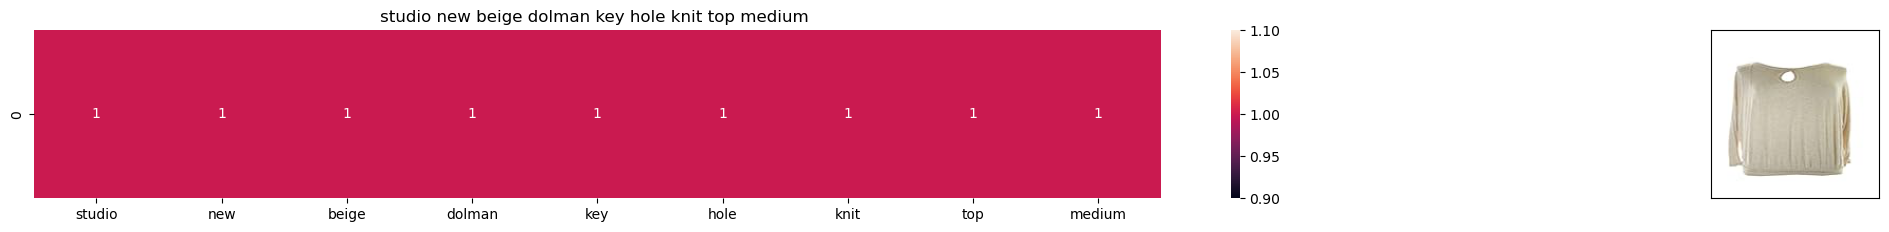

ASIN: B01ITM2VP2
BRAND: Studio M
TILES: studio new beige dolman key hole knit top medium 
Euclidean similarity with query image: 0.0


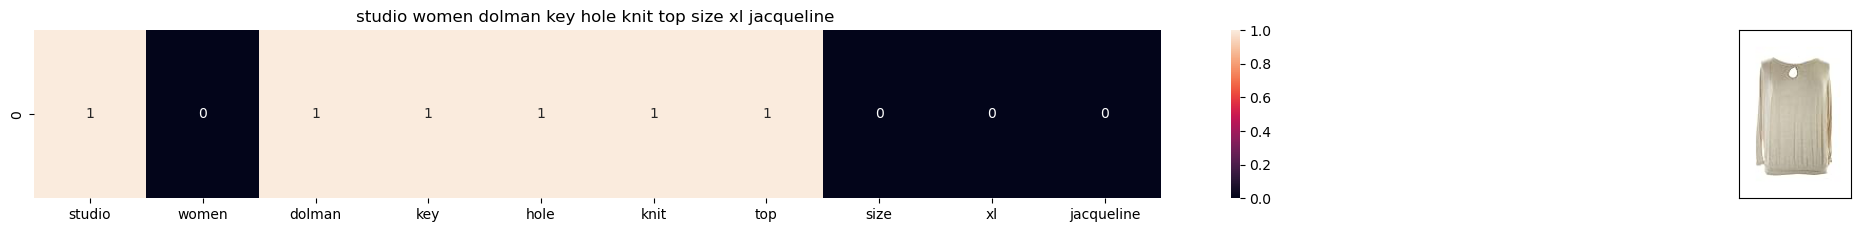

ASIN: B01KLJ805Q
BRAND: Studio M
TILES: studio women dolman key hole knit top size xl jacqueline 
Euclidean similarity with query image: 2.6457513110645907


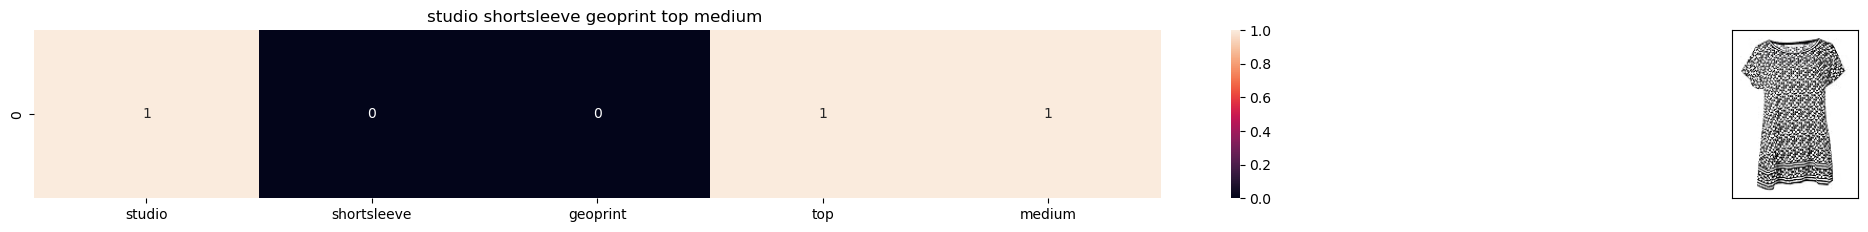

ASIN: B01I62TGGW
BRAND: Studio M
TILES: studio shortsleeve geoprint top medium 
Euclidean similarity with query image: 2.8284271247461903


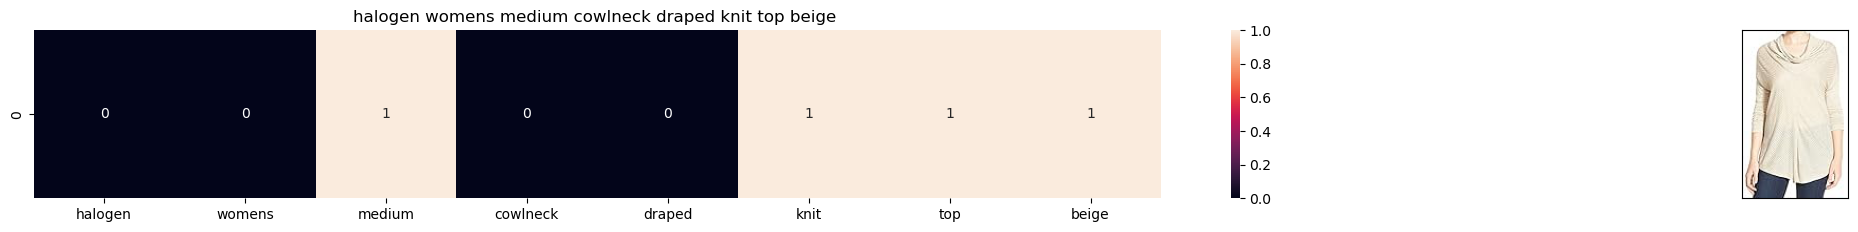

ASIN: B06XDP7YHY
BRAND: Halogen
TILES: halogen womens medium cowlneck draped knit top beige 
Euclidean similarity with query image: 3.0


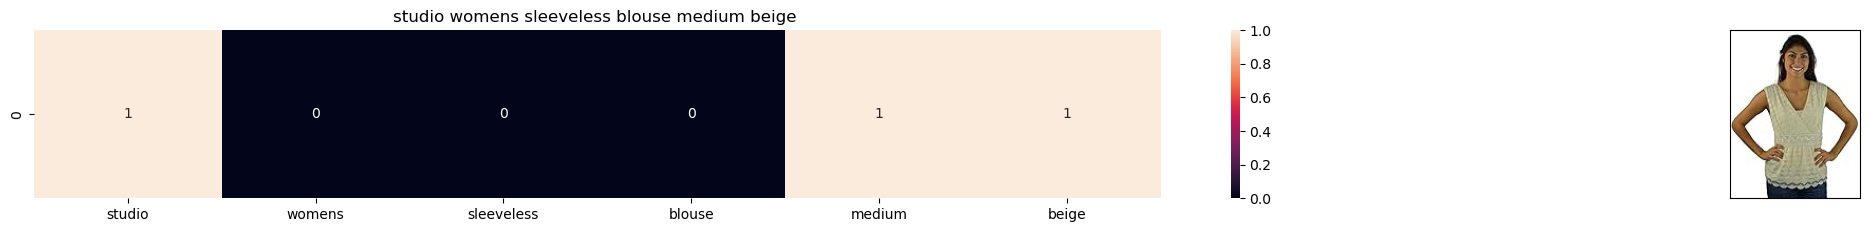

ASIN: B00QVXHHEW
BRAND: Studio M
TILES: studio womens sleeveless blouse medium beige 
Euclidean similarity with query image: 3.0


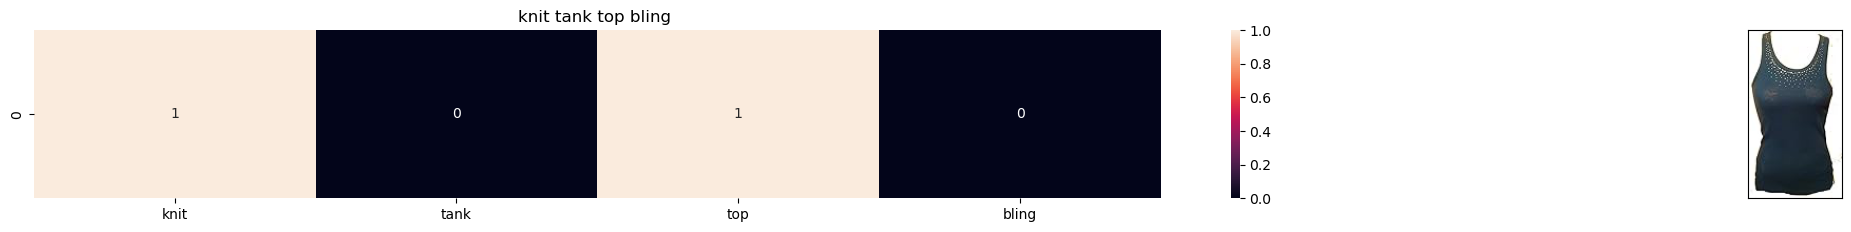

ASIN: B01NBQSBMN
BRAND: Pink Cattlelac
TILES: knit tank top bling 
Euclidean similarity with query image: 3.0


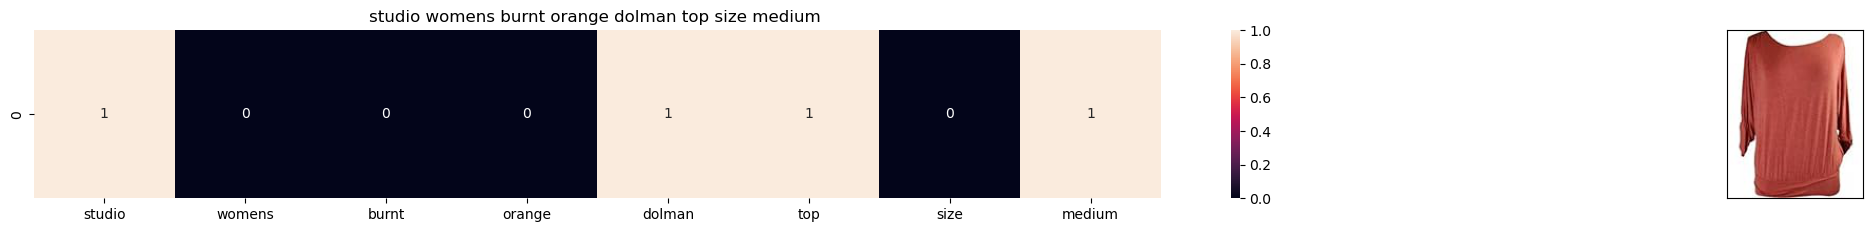

ASIN: B06XSCVFT5
BRAND: Studio M
TILES: studio womens burnt orange dolman top size medium 
Euclidean similarity with query image: 3.0


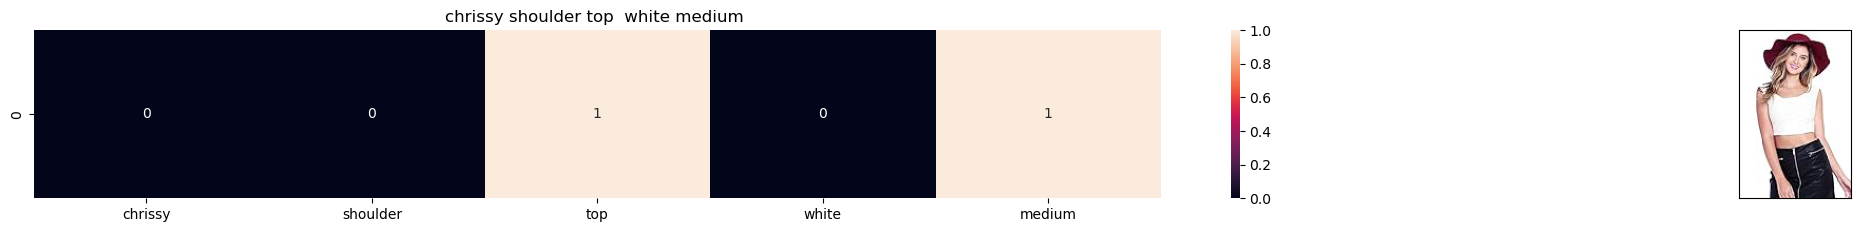

ASIN: B01IAZ4T7G
BRAND: Lushfox
TILES: chrissy shoulder top  white medium 
Euclidean similarity with query image: 3.1622776601683795


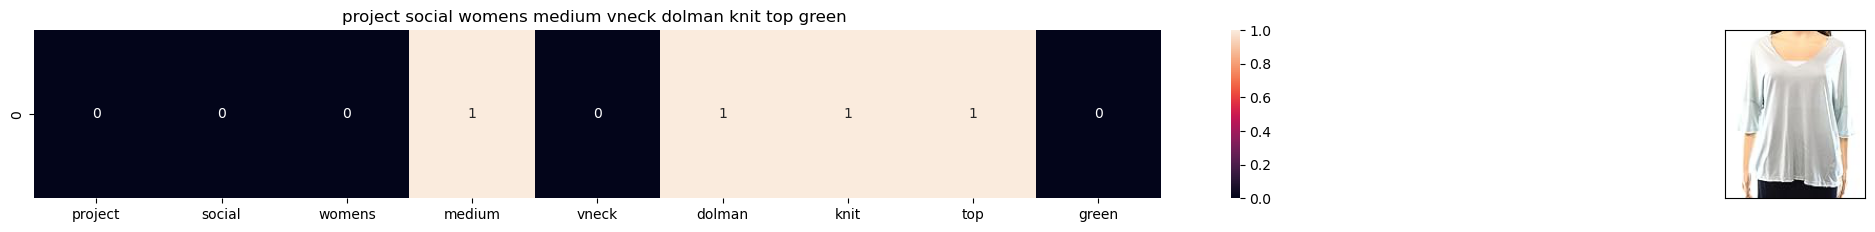

ASIN: B0731DN2XX
BRAND: Project Social T
TILES: project social womens medium vneck dolman knit top green 
Euclidean similarity with query image: 3.1622776601683795


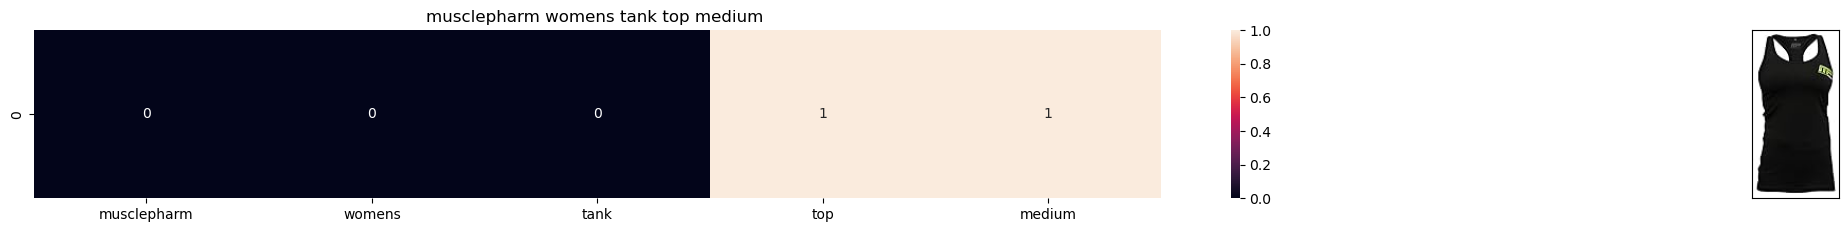

ASIN: B00I1KEPSO
BRAND: Muscle Pharm
TILES: musclepharm womens tank top medium 
Euclidean similarity with query image: 3.1622776601683795


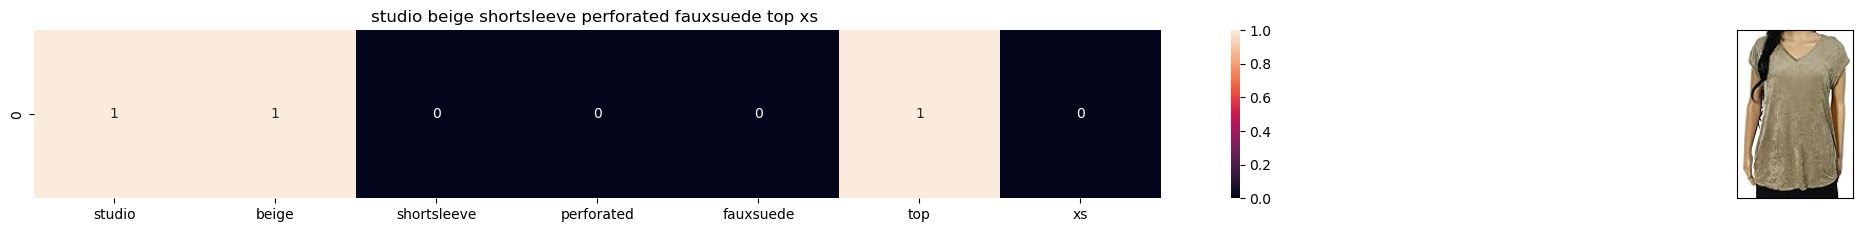

ASIN: B01N0D55RU
BRAND: Studio M
TILES: studio beige shortsleeve perforated fauxsuede top xs 
Euclidean similarity with query image: 3.1622776601683795


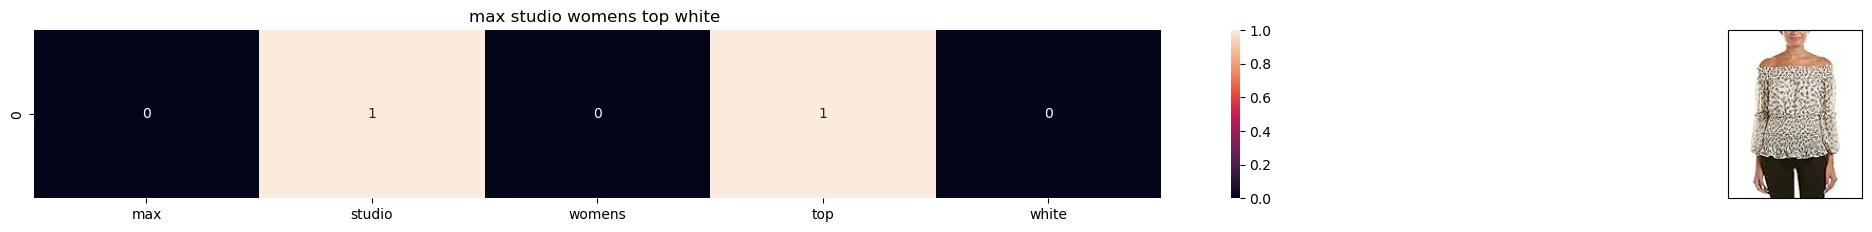

ASIN: B074LB4WN1
BRAND: MAXSTUDIO
TILES: max studio womens top white 
Euclidean similarity with query image: 3.1622776601683795


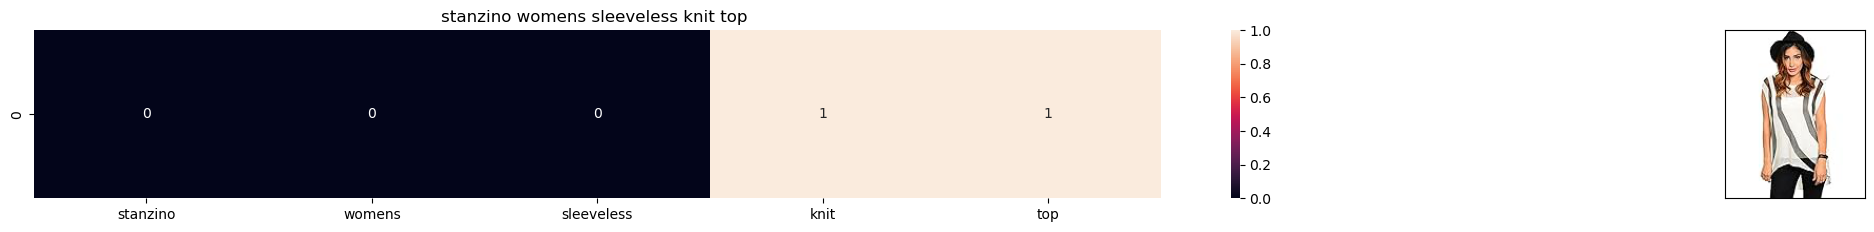

ASIN: B00OZPOQF6
BRAND: Stanzino
TILES: stanzino womens sleeveless knit top 
Euclidean similarity with query image: 3.1622776601683795


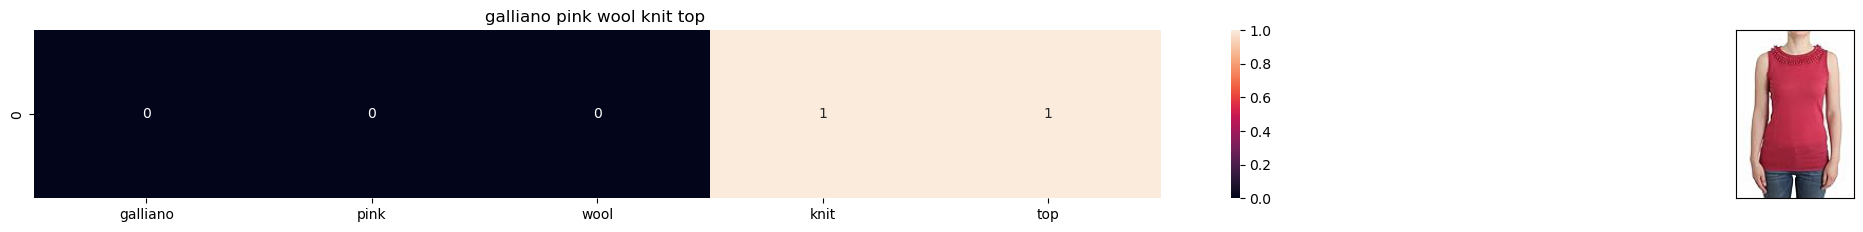

ASIN: B074G4V6NJ
BRAND: Galliano
TILES: galliano pink wool knit top 
Euclidean similarity with query image: 3.1622776601683795


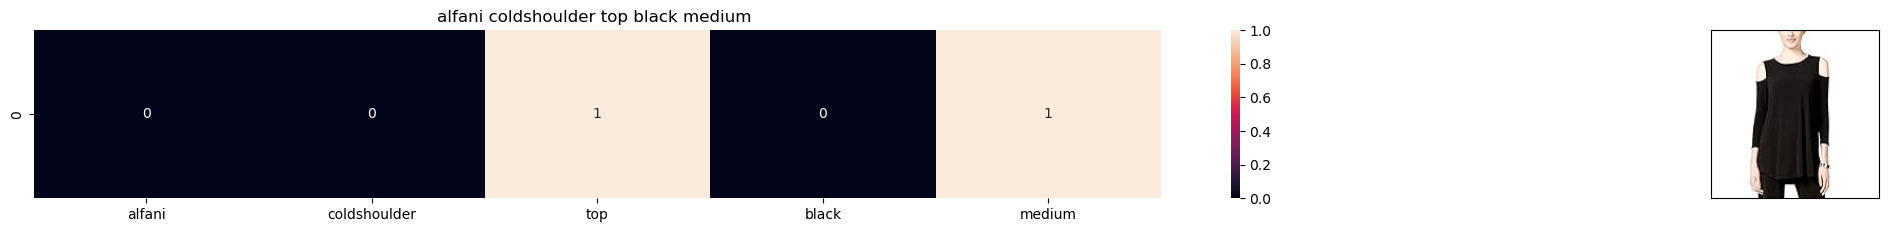

ASIN: B0741VGRZ7
BRAND: Alfani
TILES: alfani coldshoulder top black medium 
Euclidean similarity with query image: 3.1622776601683795


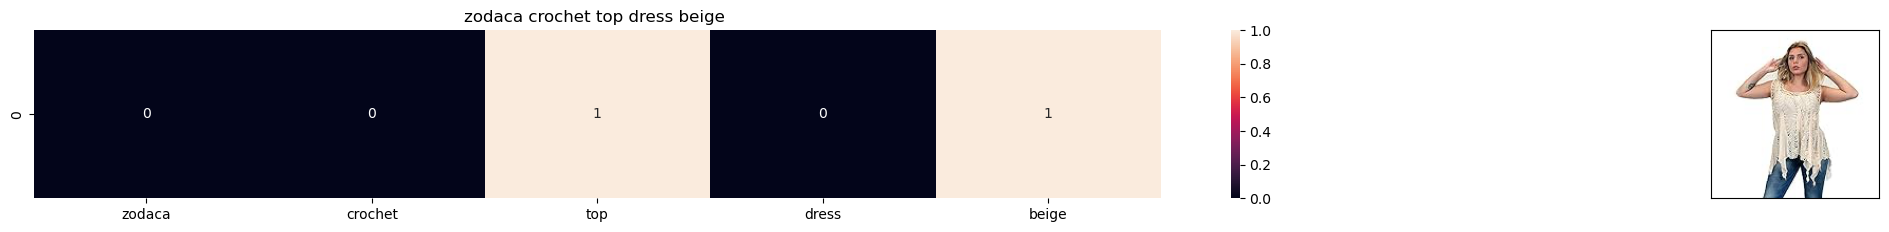

ASIN: B0732TPBC7
BRAND: Zodaca
TILES: zodaca crochet top dress beige 
Euclidean similarity with query image: 3.1622776601683795


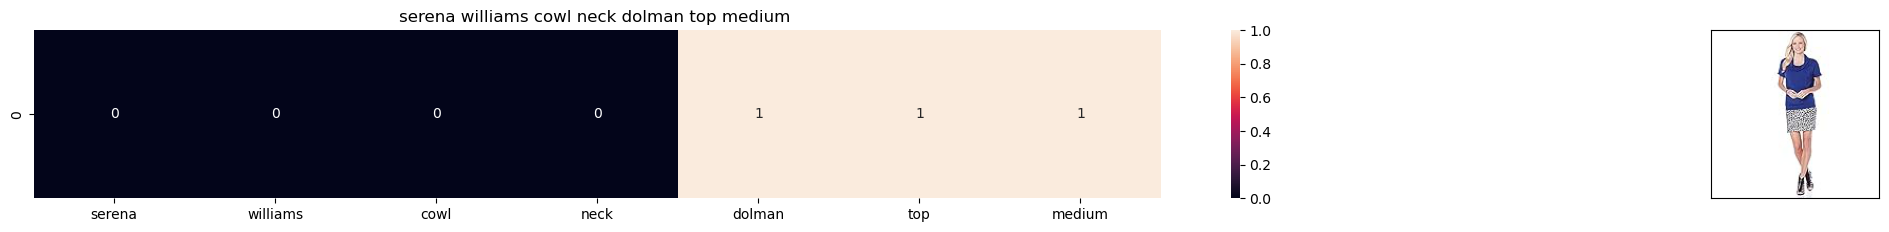

ASIN: B01MPZEUF8
BRAND: Serena Williams
TILES: serena williams cowl neck dolman top medium 
Euclidean similarity with query image: 3.1622776601683795


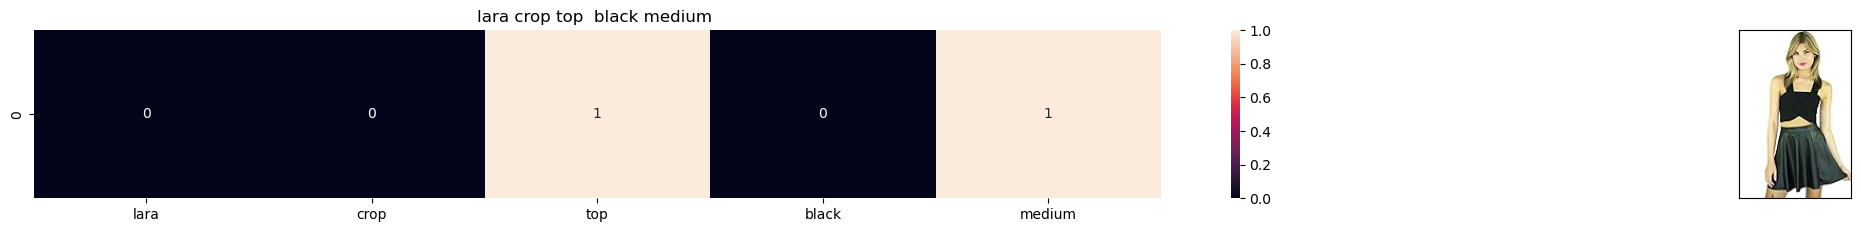

ASIN: B01HT1BR5O
BRAND: Lushfox
TILES: lara crop top  black medium 
Euclidean similarity with query image: 3.1622776601683795


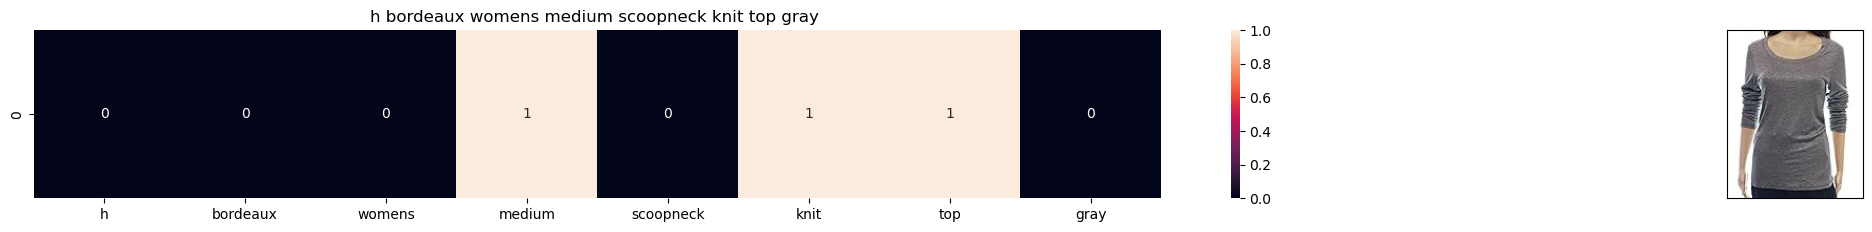

ASIN: B07177CC1X
BRAND: H By Bordeaux
TILES: h bordeaux womens medium scoopneck knit top gray 
Euclidean similarity with query image: 3.1622776601683795


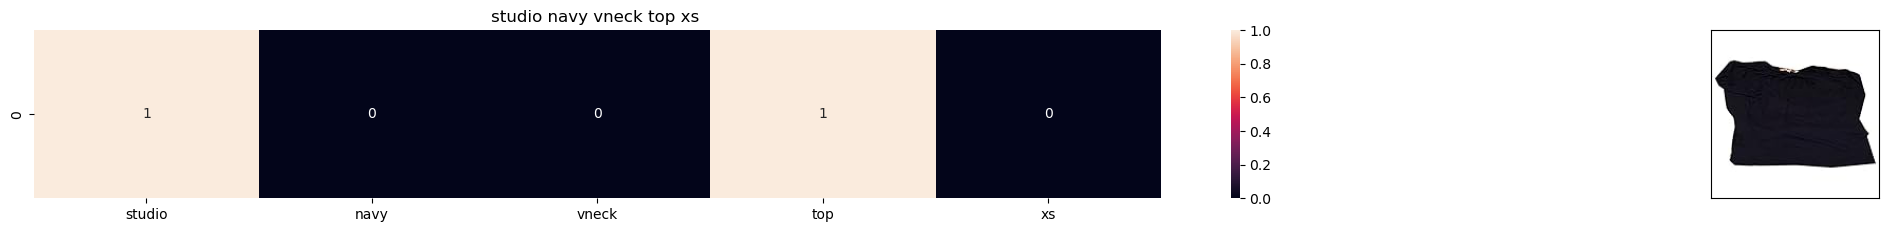

ASIN: B01J504G7I
BRAND: Studio M
TILES: studio navy vneck top xs 
Euclidean similarity with query image: 3.1622776601683795


In [58]:
def bag_of_words_model(doc_id,num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    #sorting distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the smallest distances
    pdists = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]],data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN:',data['asin'].loc[df_indices[i]])
        print('BRAND:',data['brand'].loc[df_indices[i]])
        print('TILES:',data['title'].loc[df_indices[i]])
        print('Euclidean similarity with query image:',pdists[i])
        print('='*60)

#call the bag-of-words model for a product to get similar products.
#bag_of_words_model(12566, 20) # change the index if you want to.
# In the output heat map each value represents the count value 
# of the label word, the color represents the intersection 
# with inputs title.
#call bow n our dataset
bag_of_words_model(12566,20)
        

## TF-IDF based product similarity

In [56]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 1)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])
# tfidf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(courpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# tfidf_title_features[doc_id, index_of_word_in_corpus] = tfidf values of the word in given doc

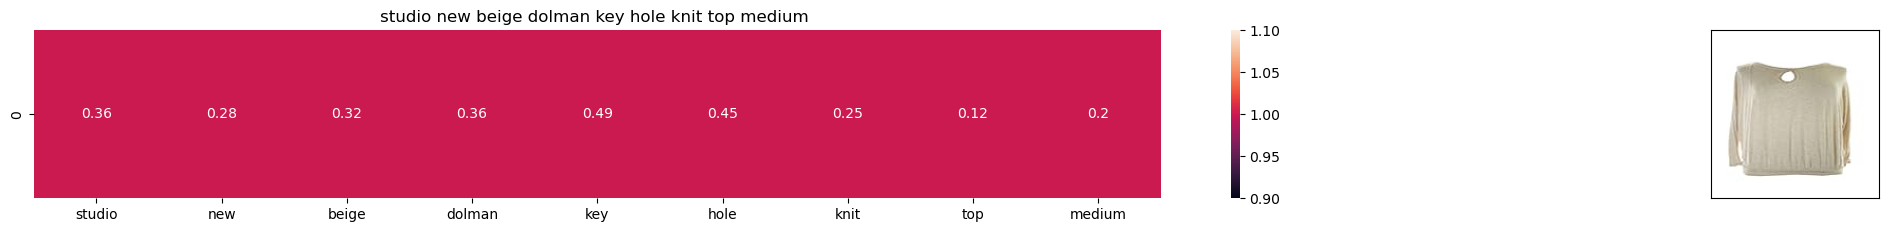

ASIN : B01ITM2VP2
BRAND : Studio M
Eucliden distance from the given image : 0.0


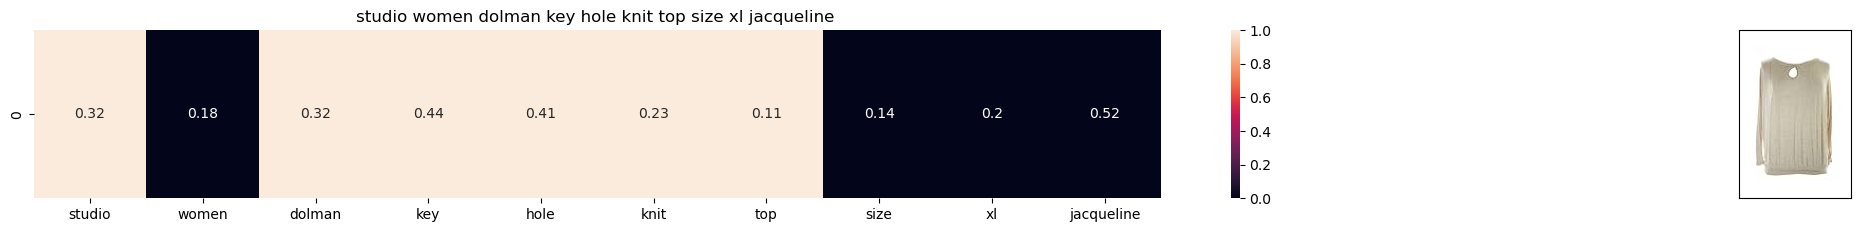

ASIN : B01KLJ805Q
BRAND : Studio M
Eucliden distance from the given image : 0.7690894134841187


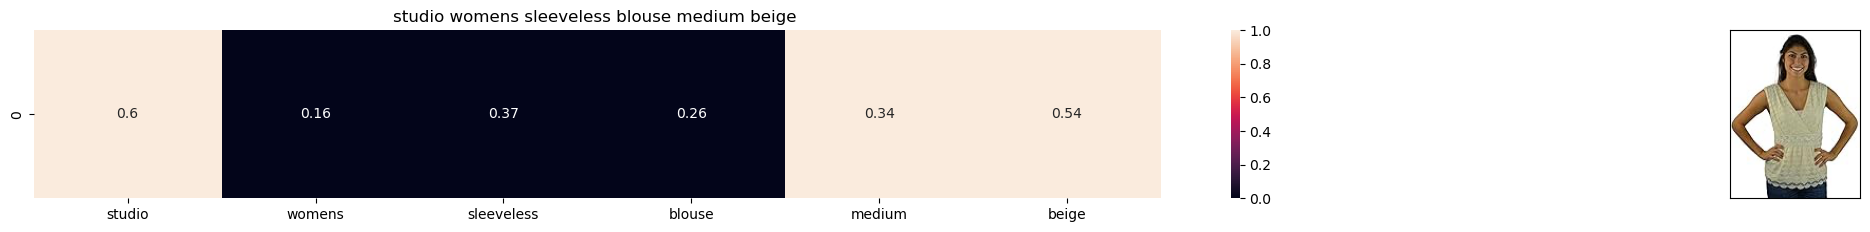

ASIN : B00QVXHHEW
BRAND : Studio M
Eucliden distance from the given image : 1.0400157111853274


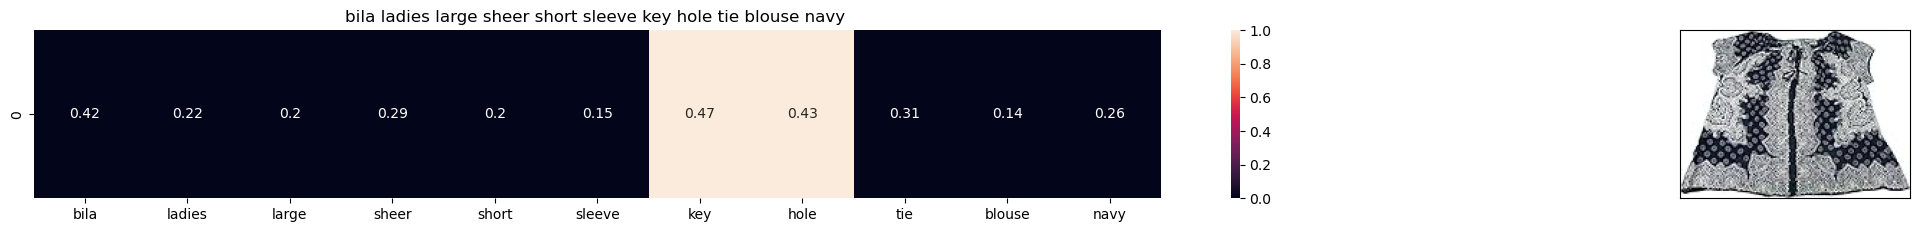

ASIN : B017BQBCSY
BRAND : Bila
Eucliden distance from the given image : 1.0739091233650173


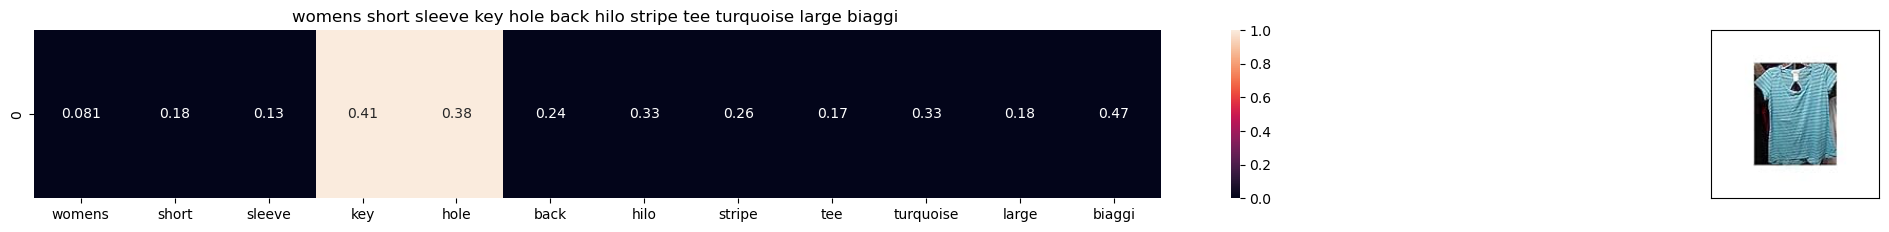

ASIN : B01EXXFT5K
BRAND : biaggi
Eucliden distance from the given image : 1.1163643517366693


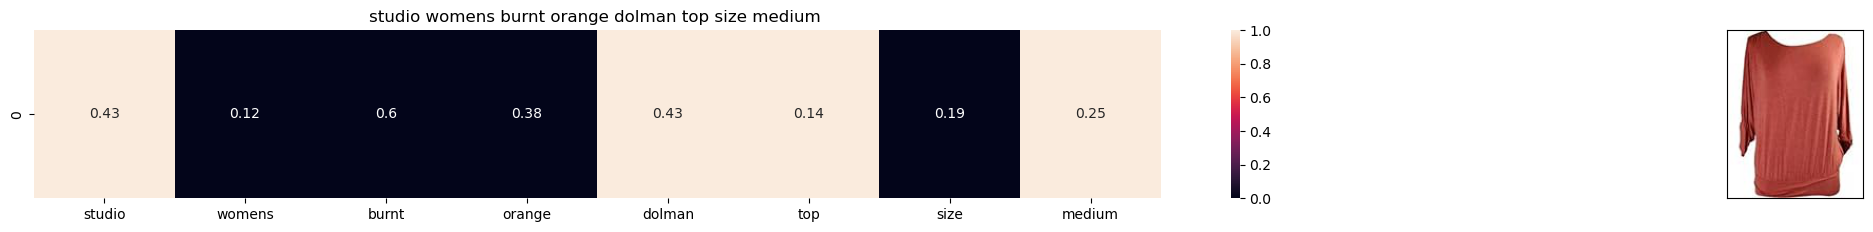

ASIN : B06XSCVFT5
BRAND : Studio M
Eucliden distance from the given image : 1.1191483804229836


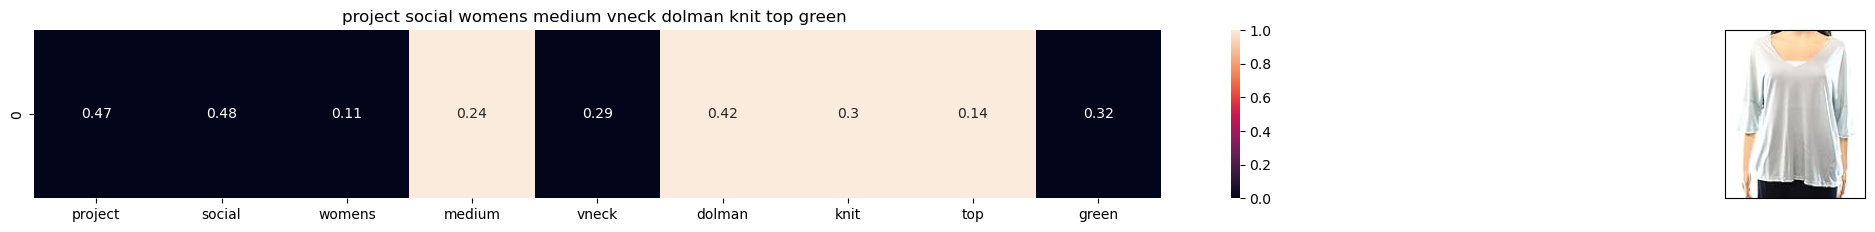

ASIN : B0731DN2XX
BRAND : Project Social T
Eucliden distance from the given image : 1.190019936184793


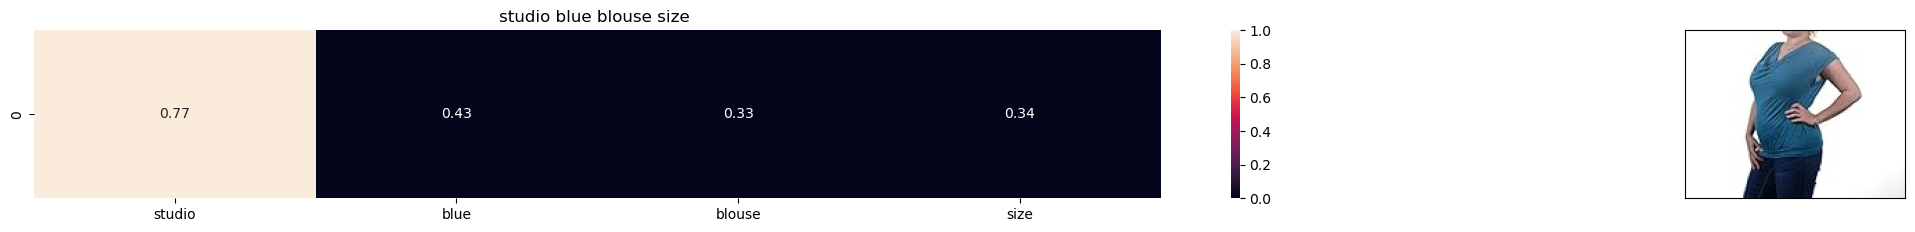

ASIN : B016P80OKQ
BRAND : Studio M
Eucliden distance from the given image : 1.2024928490804738


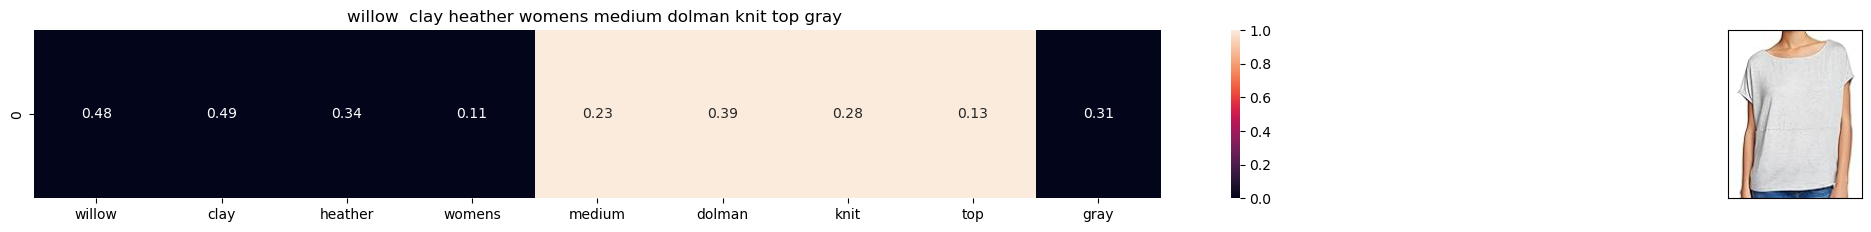

ASIN : B01L2019AG
BRAND : Willow & Clay
Eucliden distance from the given image : 1.2065909585932215


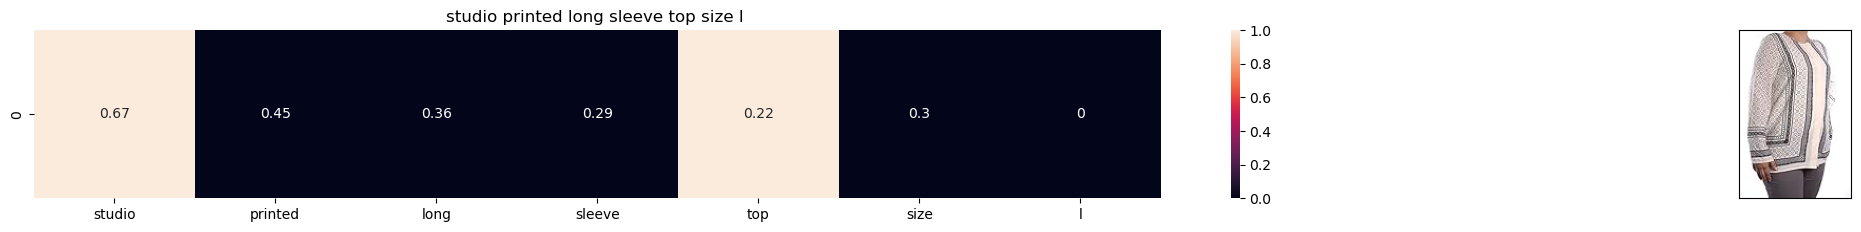

ASIN : B0155JBTLO
BRAND : Studio M
Eucliden distance from the given image : 1.21151551750774


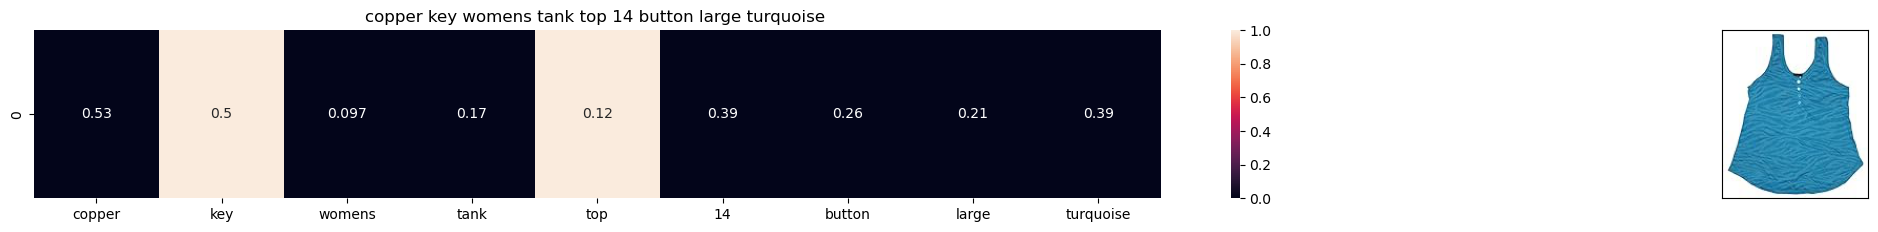

ASIN : B00T5O1COA
BRAND : Copper Key
Eucliden distance from the given image : 1.2190674530144652


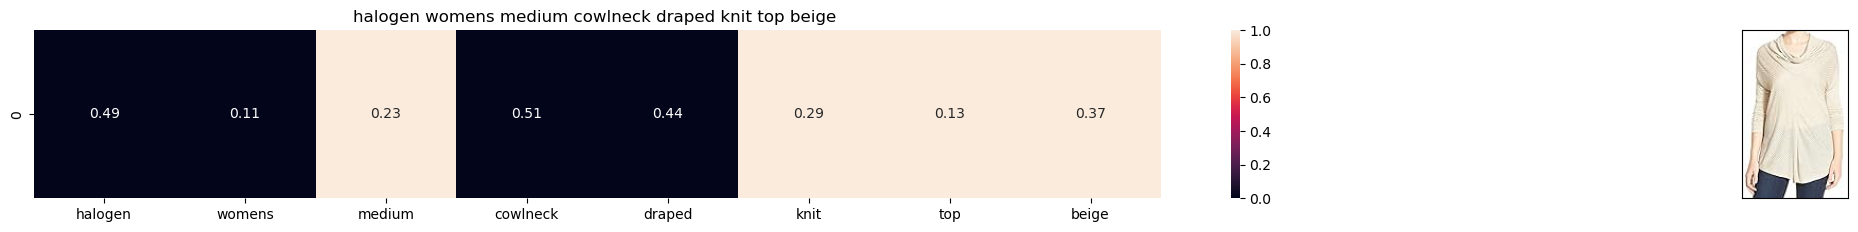

ASIN : B06XDP7YHY
BRAND : Halogen
Eucliden distance from the given image : 1.221266825987607


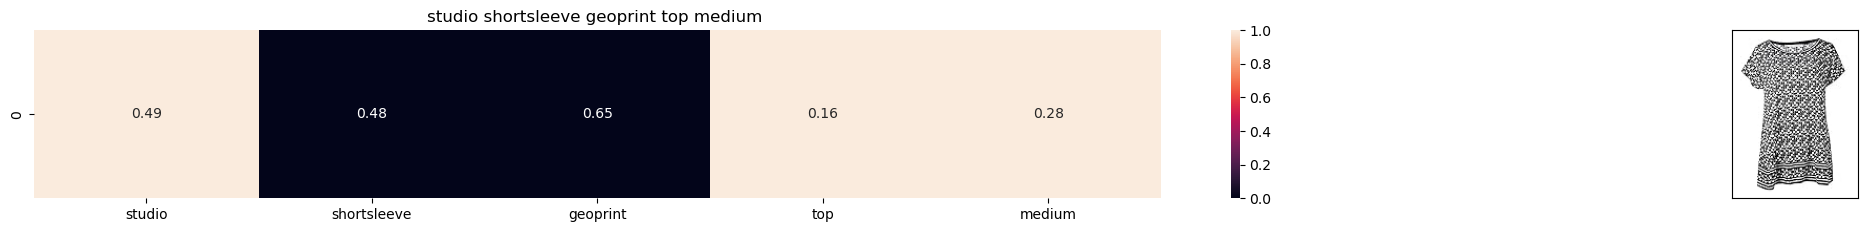

ASIN : B01I62TGGW
BRAND : Studio M
Eucliden distance from the given image : 1.221627507126044


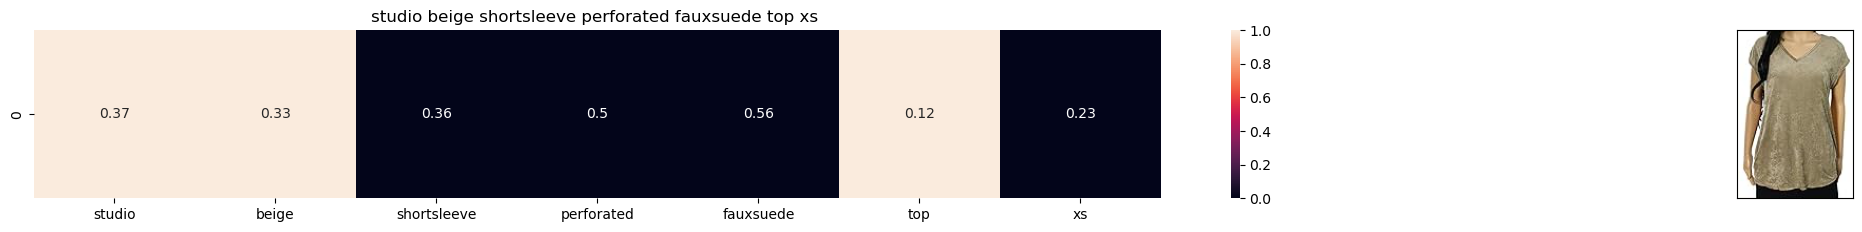

ASIN : B01N0D55RU
BRAND : Studio M
Eucliden distance from the given image : 1.2218556259493771


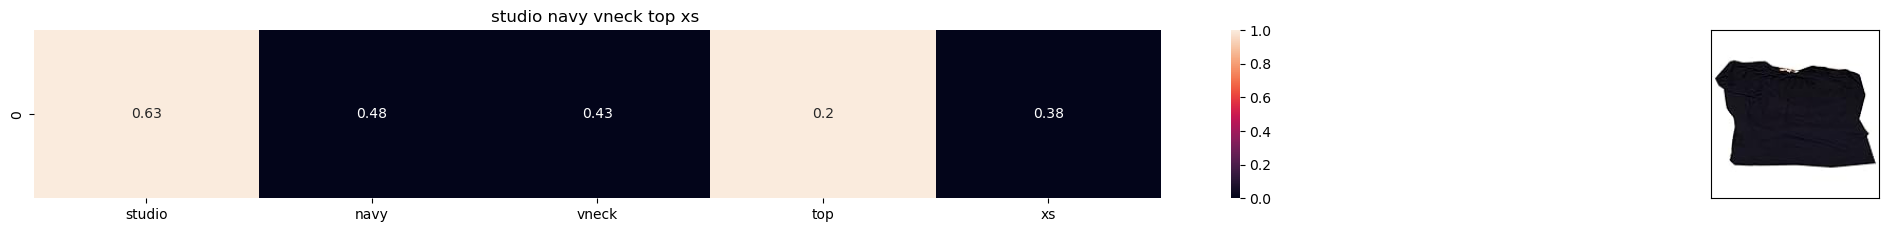

ASIN : B01J504G7I
BRAND : Studio M
Eucliden distance from the given image : 1.2249409202252306


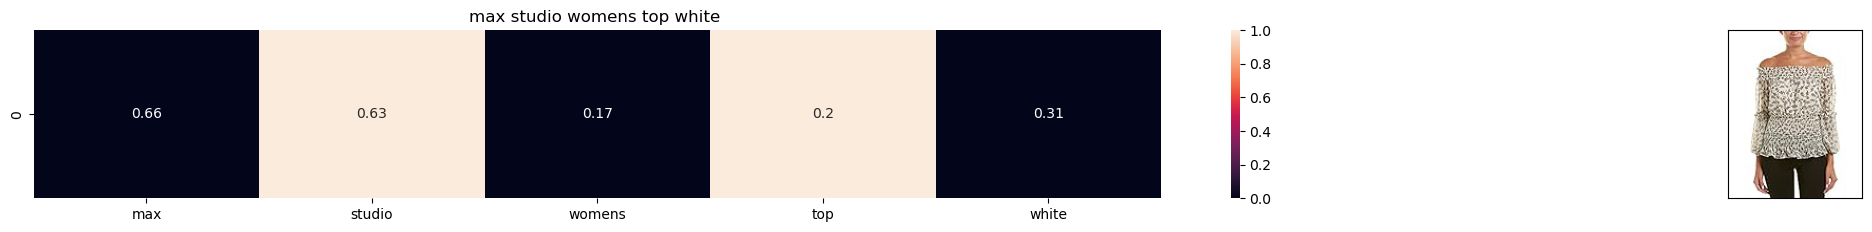

ASIN : B074LB4WN1
BRAND : MAXSTUDIO
Eucliden distance from the given image : 1.2251220211876392


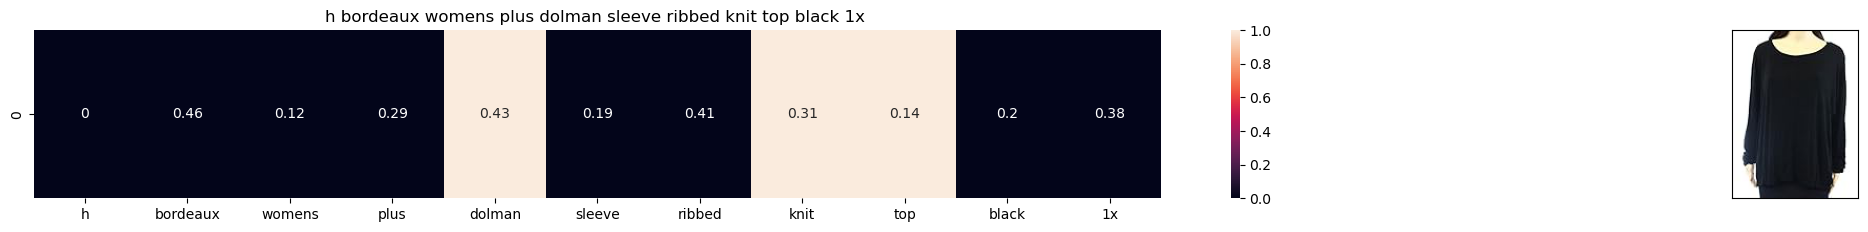

ASIN : B01M9AD4HJ
BRAND : H By Bordeaux
Eucliden distance from the given image : 1.2255560746105274


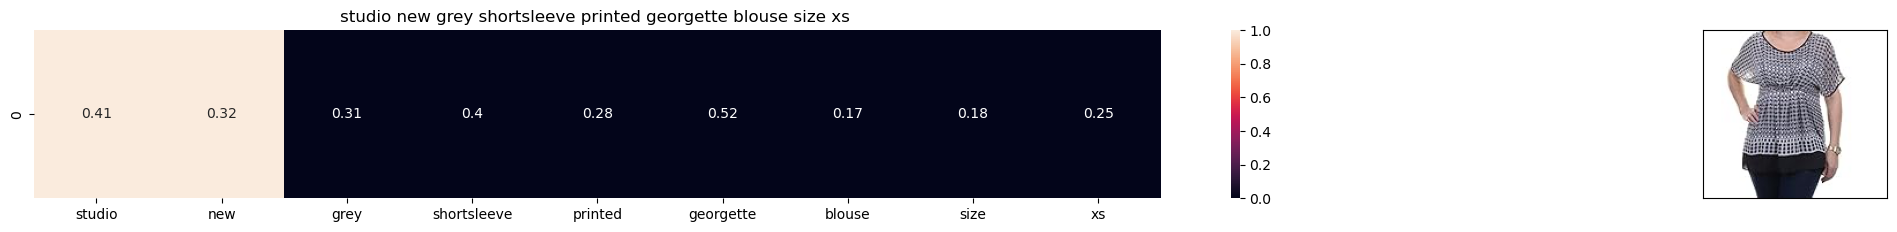

ASIN : B016YYRP6W
BRAND : Studio M
Eucliden distance from the given image : 1.2354899650436288


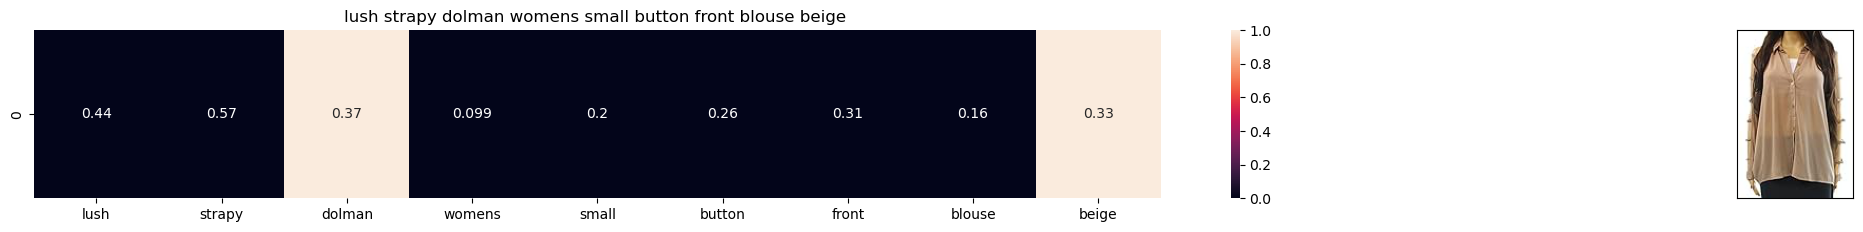

ASIN : B072126JNQ
BRAND : Lush Clothing
Eucliden distance from the given image : 1.2360838118892472


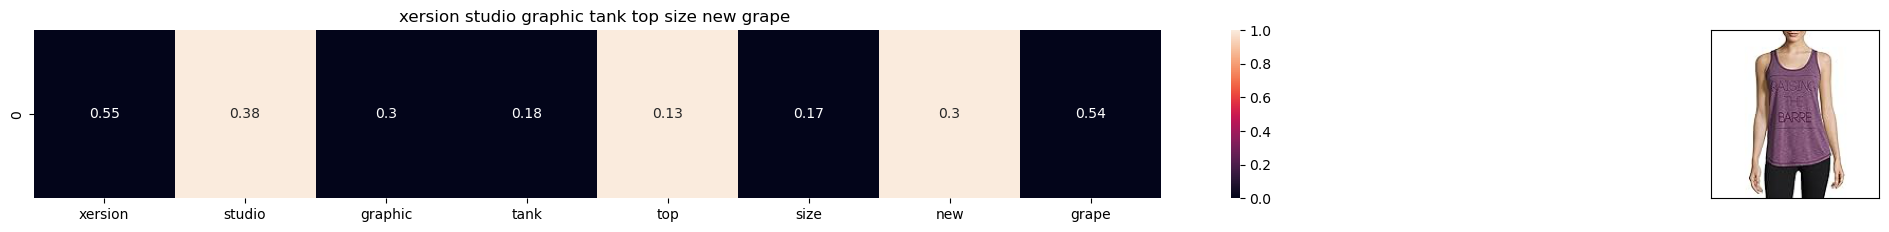

ASIN : B06XQVM7MQ
BRAND : Xersion
Eucliden distance from the given image : 1.2362708764564991


In [57]:
def tfidf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
tfidf_model(12566, 20)
# in the output heat map each value represents the tfidf values of the label word, the color represents the intersection with inputs title